In [1]:
import sys

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

from keras.datasets import cifar10
from keras.datasets import mnist

from keras.utils import to_categorical
from keras import backend as K

import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns

import pickle

class IO:
    def __init__(self, file_name):
        self.file_name = file_name
        
    def to_pickle(self, obj):
        with open(self.file_name, 'wb') as output:
            pickle.dump(obj, output, protocol=pickle.HIGHEST_PROTOCOL)
    
    def read_pickle(self):
        with open(self.file_name, 'rb') as input_:
            obj = pickle.load(input_)
        return obj

Using TensorFlow backend.


In [2]:
# Load data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X1 = np.array([rotate(X_test[9978], i, reshape=False) for i in range(60, 120, 5)])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
class LeNet:
    def __init__(self):
        model = Sequential()
        model.add(Conv2D(20, (5, 5), input_shape=(28, 28, 1), padding='same'))
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2), strides=2))
        model.add(Conv2D(50, (5, 5), padding='same'))
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2), strides=2))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10))
        model.add(Activation('softmax'))
        self.model = model
        
    def fit(self, X_train, y_train, validation_data, lr=0.01, epochs=10, batch_size=64, verbose=0):
        self.model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=lr), metrics=['accuracy'])
        self.result = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, \
                                     validation_data=validation_data, verbose=verbose)
        return self

In [4]:
%%time

lenet1 = LeNet().fit(X_train, y_train, (X_test, y_test), epochs=100, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s 229us/step - loss: 0.5608 - acc: 0.8201 - val_loss: 0.4837 - val_acc: 0.9362
Epoch 2/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.2240 - acc: 0.9312 - val_loss: 0.3296 - val_acc: 0.9524
Epoch 3/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.1680 - acc: 0.9478 - val_loss: 0.2647 - val_acc: 0.9559
Epoch 4/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.1368 - acc: 0.9587 - val_loss: 0.2231 - val_acc: 0.9623
Epoch 5/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1221 - acc: 0.9627 - val_loss: 0.2069 - val_acc: 0.9641
Epoch 6/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1105 - acc: 0.9661 - val_loss: 0.1888 - val_acc: 0.9669
Epoch 7/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.1011 - acc: 0.9686 - val_l

Epoch 59/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0282 - acc: 0.9907 - val_loss: 0.0599 - val_acc: 0.9847
Epoch 60/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.0289 - acc: 0.9910 - val_loss: 0.0558 - val_acc: 0.9862
Epoch 61/100
60000/60000 [==============================] - 10s 162us/step - loss: 0.0282 - acc: 0.9908 - val_loss: 0.0529 - val_acc: 0.9871
Epoch 62/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0279 - acc: 0.9905 - val_loss: 0.0491 - val_acc: 0.9876
Epoch 63/100
60000/60000 [==============================] - 10s 162us/step - loss: 0.0268 - acc: 0.9915 - val_loss: 0.0575 - val_acc: 0.9847
Epoch 64/100
60000/60000 [==============================] - 10s 163us/step - loss: 0.0270 - acc: 0.9911 - val_loss: 0.0592 - val_acc: 0.9841
Epoch 65/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0273 - acc: 0.9912 - val_loss: 0.0485 - val_acc: 0.9877
Epoch 66/100


In [5]:
def predict(model, X, T=1000):
    standard_pred = model.predict_classes(X)
    f1 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-2].output])
    f2 = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    y1 = np.array([f1([X, 1]) for _ in range(T)]).squeeze()
    y2 = np.array([f2([X, 1]) for _ in range(T)]).squeeze()
    return standard_pred, y1, y2

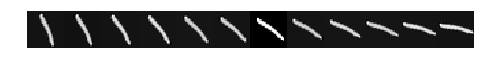

In [6]:
plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1[i].squeeze(), cmap='gray');
    plt.axis('off');

In [7]:
%%time

y1_pred, y1_si, y1_so = predict(lenet1.model, X1)
print(y1_pred)

[1 1 1 1 1 5 5 5 7 7 7 7]
CPU times: user 4.47 s, sys: 672 ms, total: 5.14 s
Wall time: 3.7 s


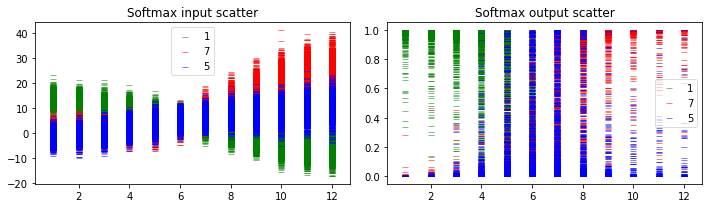

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 5].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='5');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.5, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.5, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 5].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.5, label='5');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();